In [37]:
## STANDARD IMPORTS
import os
import time
import h5py
import numpy as np
import numpy.ma as ma
import pandas as pd
import json

!pip install ../../../h5flow
import h5flow
from h5flow.data import dereference

## 3D PLOTTING
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm

Processing /Users/james/DUNE/h5flow
  Preparing metadata (setup.py) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31486 sha256=51735278b33625d9352ae4c0590aef1f58ac9b34ef318071f0340c18d9307cc6
  Stored in directory: /private/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/pip-ephem-wheel-cache-f29kksmv/wheels/24/88/52/69f8c19ba5cdb192c9c8611f03e4d3b4e2b4c27d2131bc4e20
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [38]:
#dirname = 'data_processed_mpd_run_hvramp_rctl_105_p350.FLOW_TrapType_evts_all'
dirname = 'mc_processed_MiniRun5_1E19_RHC.flow.0000000.FLOW_TrapType_evts_all'
spes_filename = dirname+'/spes_evt.npz'
noise_filename = dirname+'/noise_evt.npz'
config_filename = dirname+'/config.json'
hits_filename = dirname+'/hits_evt.npz'
hits_config_filename = dirname+'/hits_config.json'
true_hits_filename = dirname+'/true_nu_int.csv'

# check if true hits file exists
if os.path.exists(true_hits_filename):
    true_hits = pd.read_csv(true_hits_filename)
    print(true_hits.head())

# print configuration and hit configuration
with open(config_filename) as json_file:
    config = json.load(json_file)
    print(json.dumps(config, indent=4))
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
    print(json.dumps(hits_config, indent=4))

   file_idx  event_id  tpc_num  start_time  start_time_idx         v_x  \
0       0.0       1.0     -1.0    0.760375            48.0  575.664917   
1       0.0       1.0      1.0    6.066433           379.0   15.857863   
2       0.0       2.0     -1.0    8.164659           510.0 -342.153961   
3       0.0       2.0     -1.0    9.065336           567.0   98.637550   
4       0.0       3.0     -1.0    1.235837            77.0 -122.665771   

          v_y          v_z  
0  110.570198 -1463.731812  
1   43.832363   -36.580154  
2  702.277405 -2859.724609  
3 -144.412003     4.855194  
4  708.711792    -5.943815  
{
    "timestamp": "2025-01-08 15:26:06.391396",
    "filename": "../hdf5s/MiniRun5_1E19_RHC.flow.0000000.FLOW.hdf5",
    "is_data": false,
    "save_truth": true,
    "summed": "TrapType",
    "max_evts": null,
    "calib_filename": "calibration/mc_calib.csv",
    "geom_filename": "geom_files/light_module_desc-4.0.0.csv",
    "channel_status_filename": "channel_status/channel_s

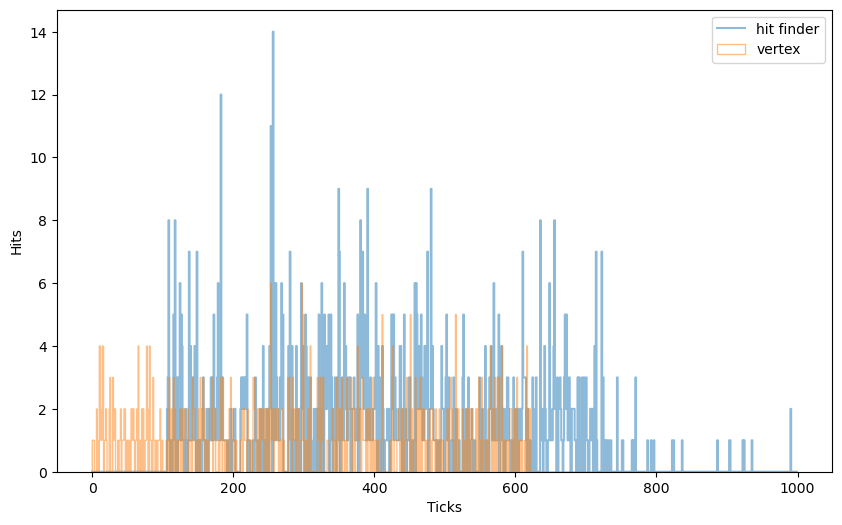

In [49]:
# load true hits
true_hits = pd.read_csv(true_hits_filename)
true_hit_idxs = true_hits['start_time_idx'].values

# load ticks histogram of all hits
hits_file = np.load(hits_filename)
hits_arr = hits_file['arr_0']
flat_hits = np.sum(hits_arr, axis=(0,1))

# plot ticks histogram of all hits
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.step(range(len(flat_hits)), flat_hits, label='hit finder', alpha=0.5)
ax.hist(true_hit_idxs, bins=range(len(flat_hits)), histtype='step', label='vertex', alpha=0.5)
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()




In [40]:
def plot_waveform(wvfm, time_bins, height, mad, n_mad_factor, dynamic_threshold, hit_where, n_noise_factor, i_evt_lrs, i_mask, true_hits=None):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
  # set a title
  fig.suptitle(f'Event {i_evt_lrs}, TPC {i_mask // 2}, TrapType {i_mask % 2}')

  # Linear plot
  ax1.plot(time_bins, wvfm)
  ax1.axhspan(-mad, mad, color='k', alpha=0.1, label='MAD')
  ax1.axhline(mad*n_mad_factor, color='k', linestyle='--', alpha=0.5, label='MAD threshold')
  ax1.axhspan(-height, height, color='r', alpha=0.1, label='Masked samples Stddev')
  ax1.axhline(n_noise_factor*height, color='r', linestyle='--', alpha=0.5, label='Noise threshold')
  ax1.plot(time_bins, dynamic_threshold, color='g', alpha=0.5)
  ax1.plot(hit_where * 16/1000, wvfm[hit_where], 'x', color='red')
  ax1.axhline(0, color='k', linestyle=':', alpha=0.5)
  for hit_idx in true_hits:
    ax1.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5, label='True hits')
  ax1.set_xlabel('Time (us)')
  ax1.set_ylabel('SPEs')
  ax1.legend()

  # Logarithmic plot
  ax2.plot(time_bins, wvfm + 1)
  ax2.axhspan(0, mad + 1, color='k', alpha=0.1)
  ax2.axhline(mad*n_mad_factor + 1, color='k', linestyle='--', alpha=0.5)
  ax2.axhspan(0, height + 1, color='r', alpha=0.1)
  ax2.axhline(n_noise_factor*height+1, color='r', linestyle='--', alpha=0.5)
  ax2.plot(time_bins, dynamic_threshold + 1, color='g', alpha=0.5)
  ax2.plot(hit_where * 16/1000, wvfm[hit_where] + 1, 'x', color='red')
  ax2.axhline(1, color='k', linestyle=':', alpha=0.5)
  for hit_idx in true_hits:
    ax2.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5)
  ax2.set_yscale('log')
  ax2.set_xlabel('Time (us)')
  ax2.set_ylim(0.1, dynamic_threshold.max()*1.1)

  plt.tight_layout()
  plt.show()

     file_idx  event_id  tpc_num  start_time  start_time_idx         v_x  \
0         0.0       1.0     -1.0    0.760375            48.0  575.664917   
1         0.0       1.0      1.0    6.066433           379.0   15.857863   
2         0.0       2.0     -1.0    8.164659           510.0 -342.153961   
3         0.0       2.0     -1.0    9.065336           567.0   98.637550   
4         0.0       3.0     -1.0    1.235837            77.0 -122.665771   
..        ...       ...      ...         ...             ...         ...   
611       0.0     196.0     -1.0    4.538300           284.0 -122.864120   
612       0.0     197.0     -1.0    9.863215           616.0 -118.984421   
613       0.0     198.0     -1.0    0.190897            12.0 -131.651993   
614       0.0     198.0     -1.0    7.404943           463.0  -57.345200   
615       0.0     198.0     -1.0    9.122297           570.0  439.340698   

            v_y          v_z  
0    110.570198 -1463.731812  
1     43.832363   -36.580

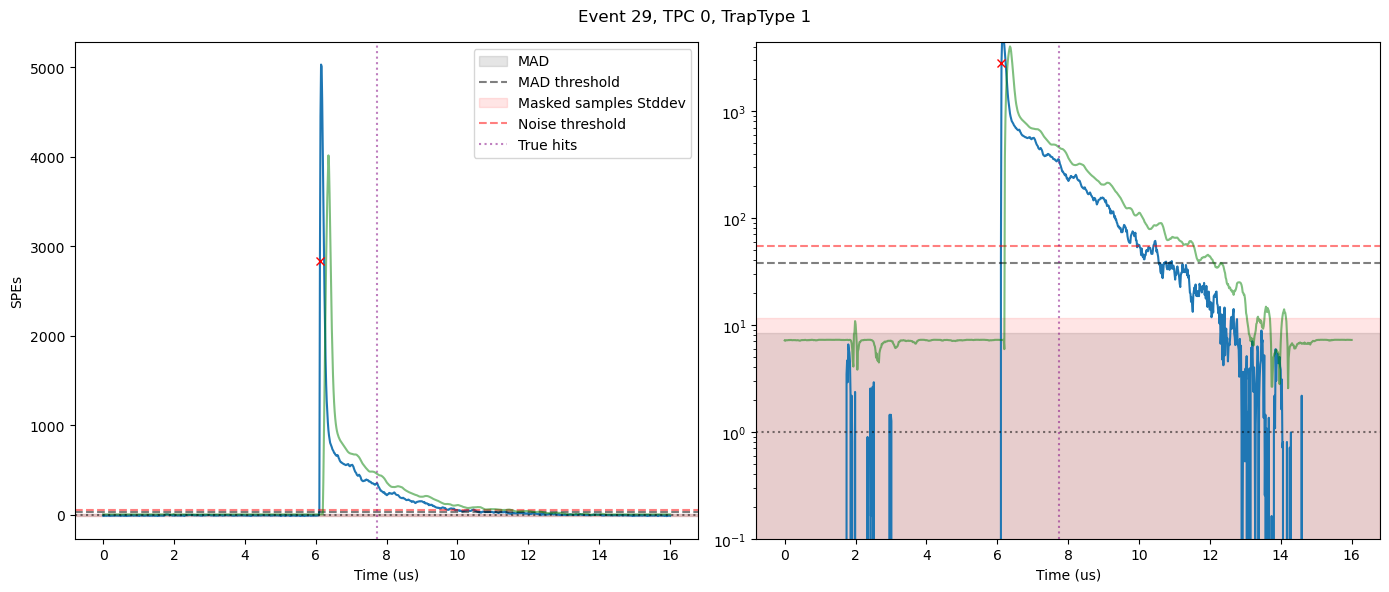

In [41]:
from scipy.ndimage import uniform_filter1d

# load hit finder config
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
n_noise_factor = hits_config['n_noise_factor']
n_bins_rolled = hits_config['n_bins_rolled']
n_sqrt_rt_factor = hits_config['n_sqrt_rt_factor']
pe_weight = hits_config['pe_weight']


# loading events
time_bins = np.linspace(0, 16, 1000)

# wvfms
summed_wvfms_file = np.load(spes_filename)
summed_wvfms = np.array(summed_wvfms_file['arr_0'])

# noise thresholds
heights_file = np.load(noise_filename)
heights = np.array(heights_file['arr_0'])

# loading hits
hits_file = np.load(hits_filename)
hits = np.array(hits_file['arr_0'])

# find first event with hits != -1
i_evt_lrs = 29 #3705 # event number
i_tpc = 0
i_mask = 2*i_tpc + 1 # 2 * TPC + TrapType

# load true hits in TPC 2 in event 0
true_hits_tpc = true_hits[(true_hits['tpc_num'] == i_tpc) & (true_hits['event_id'] == i_evt_lrs)]
true_hits_idx = true_hits_tpc['start_time_idx'].values
print(true_hits)

# get wvfm, threshold, and hits for the event
wvfm = summed_wvfms[i_evt_lrs,i_mask]
median = np.median(wvfm)
mad = np.median(np.abs(wvfm - median))
mad_threshold = 5*mad
wvfm_rolled = np.roll(wvfm, n_bins_rolled)
rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
height = heights[i_evt_lrs,i_mask]
hit = hits[i_evt_lrs,i_mask]
hit_where = np.where(hit)[0]
print(hit_where)

plot_waveform(wvfm, time_bins, height, mad, 5.0, dynamic_threshold, hit_where, n_noise_factor, i_evt_lrs, i_mask, true_hits_idx)


Event 1, TPC 1, TrapType 1 [379.] []


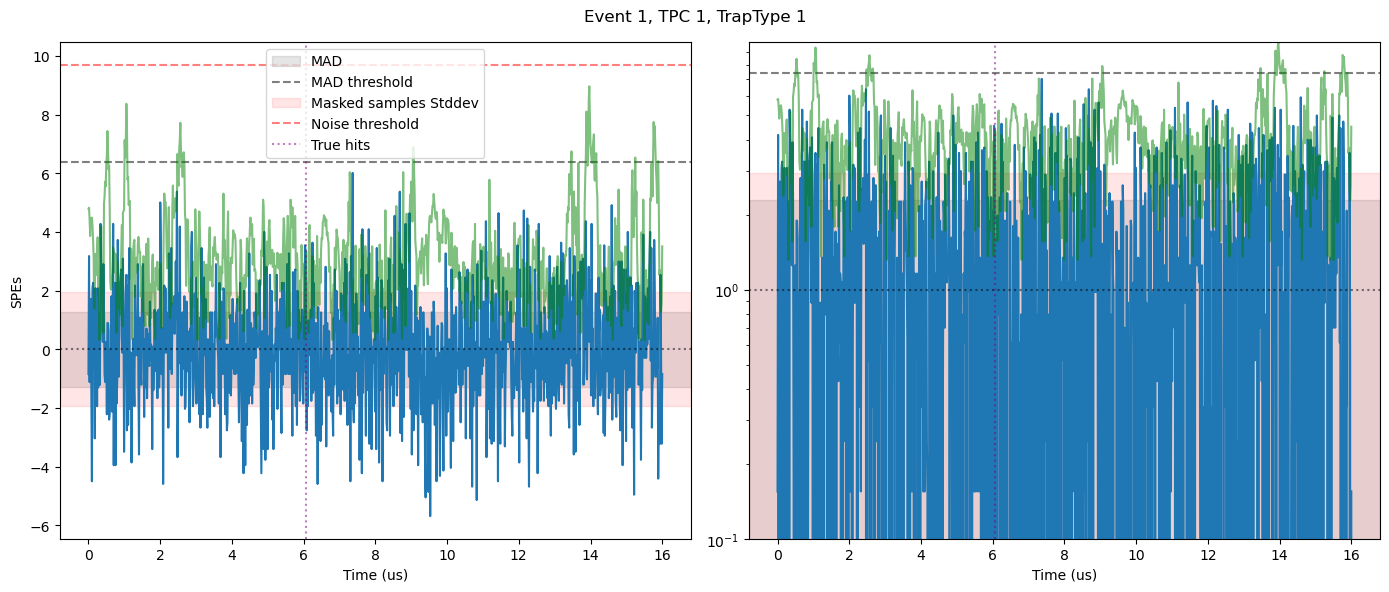

Event 12, TPC 0, TrapType 1 [261.] []


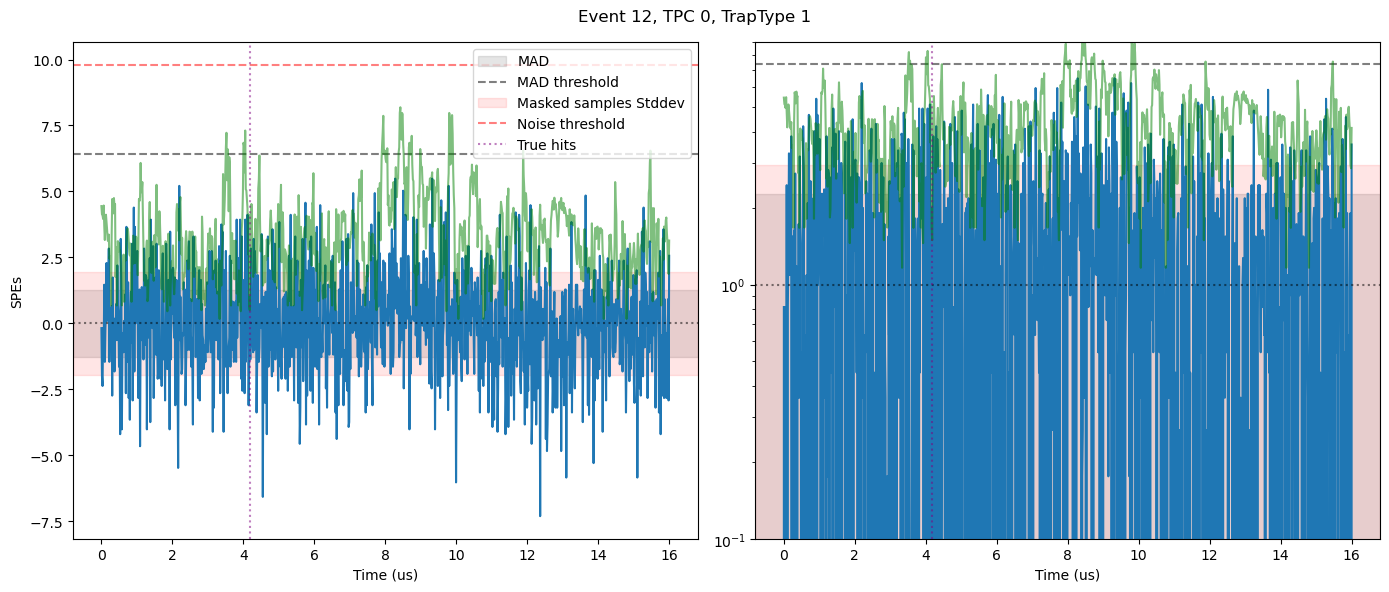

Event 14, TPC 3, TrapType 1 [182.] [660 745]


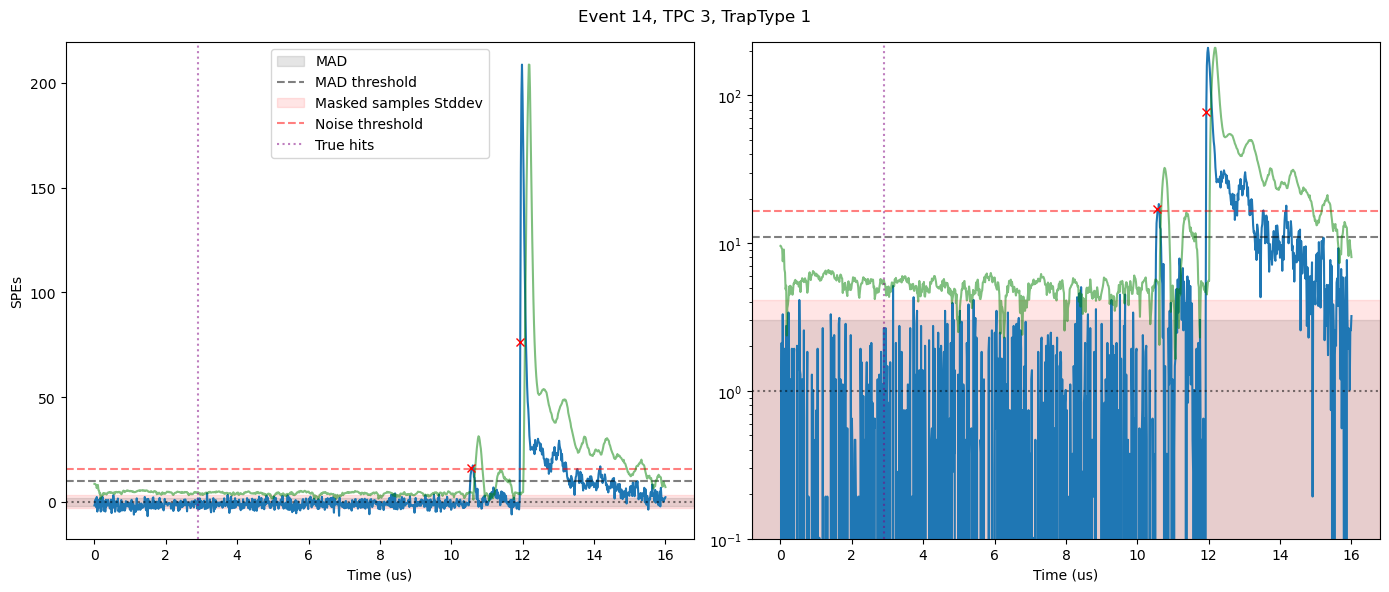

Event 29, TPC 0, TrapType 1 [483.] [382]


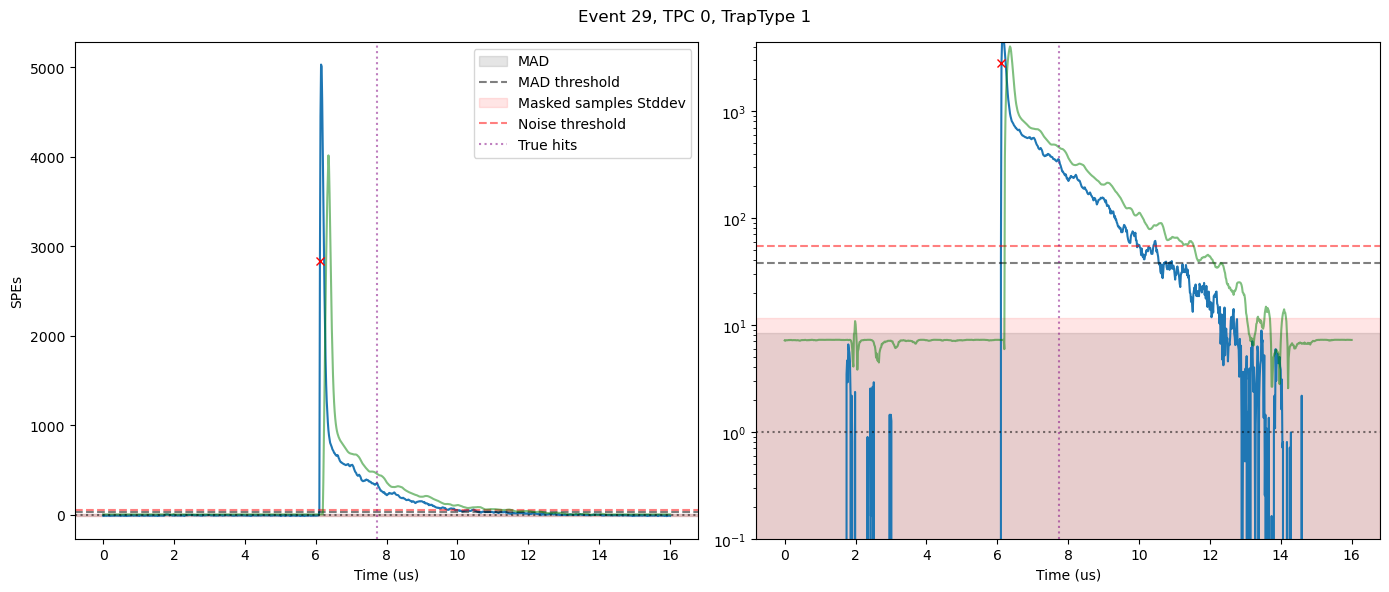

Event 29, TPC 1, TrapType 1 [297.] [381 394]


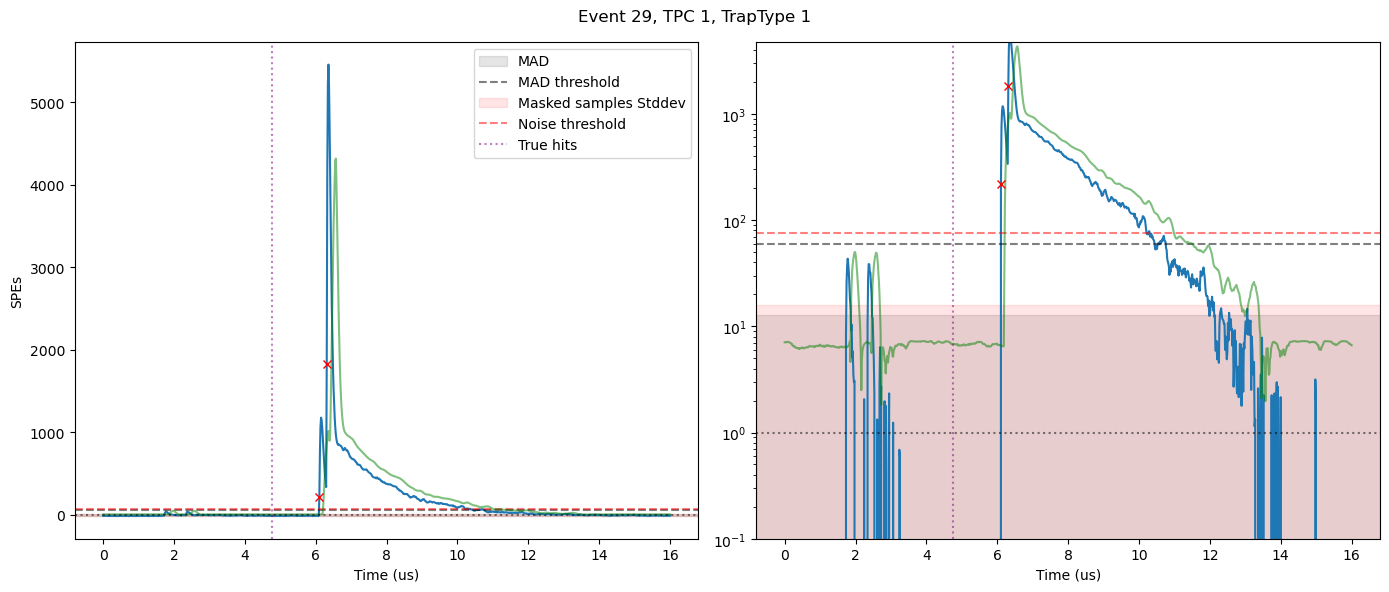

Event 29, TPC 3, TrapType 1 [589.] [108 381 396]


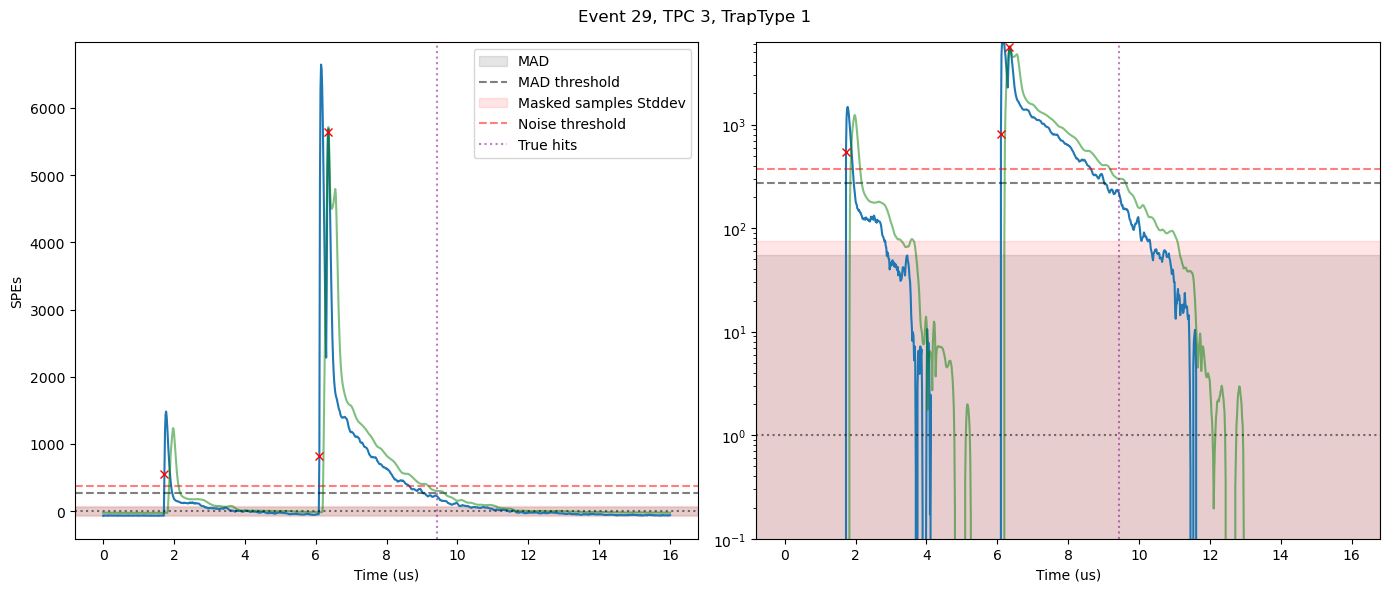

Event 31, TPC 3, TrapType 1 [6.] [387]


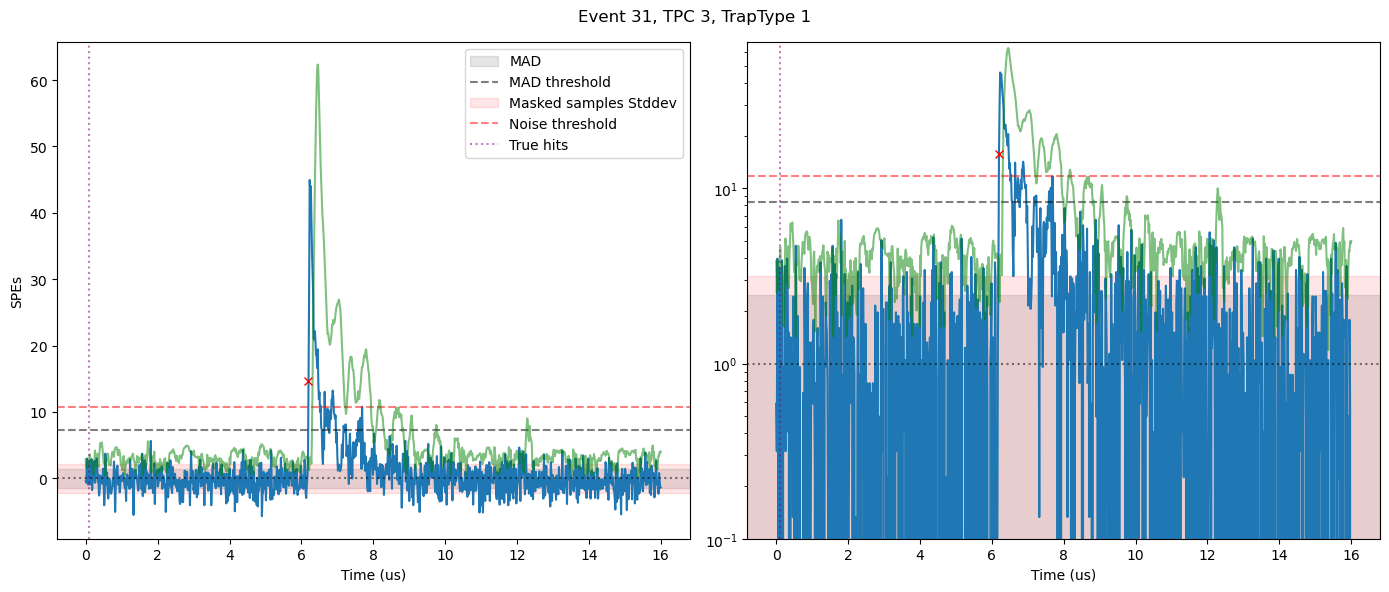

Event 35, TPC 1, TrapType 1 [365.] [201]


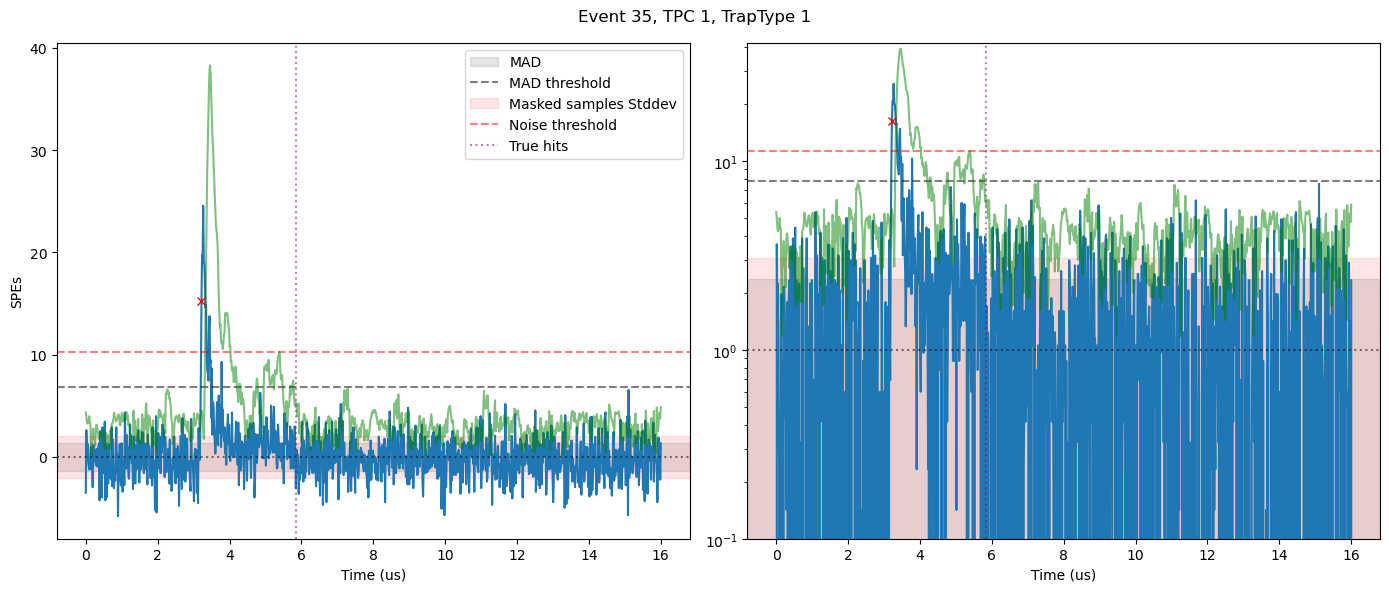

Event 35, TPC 2, TrapType 1 [519.] [577]


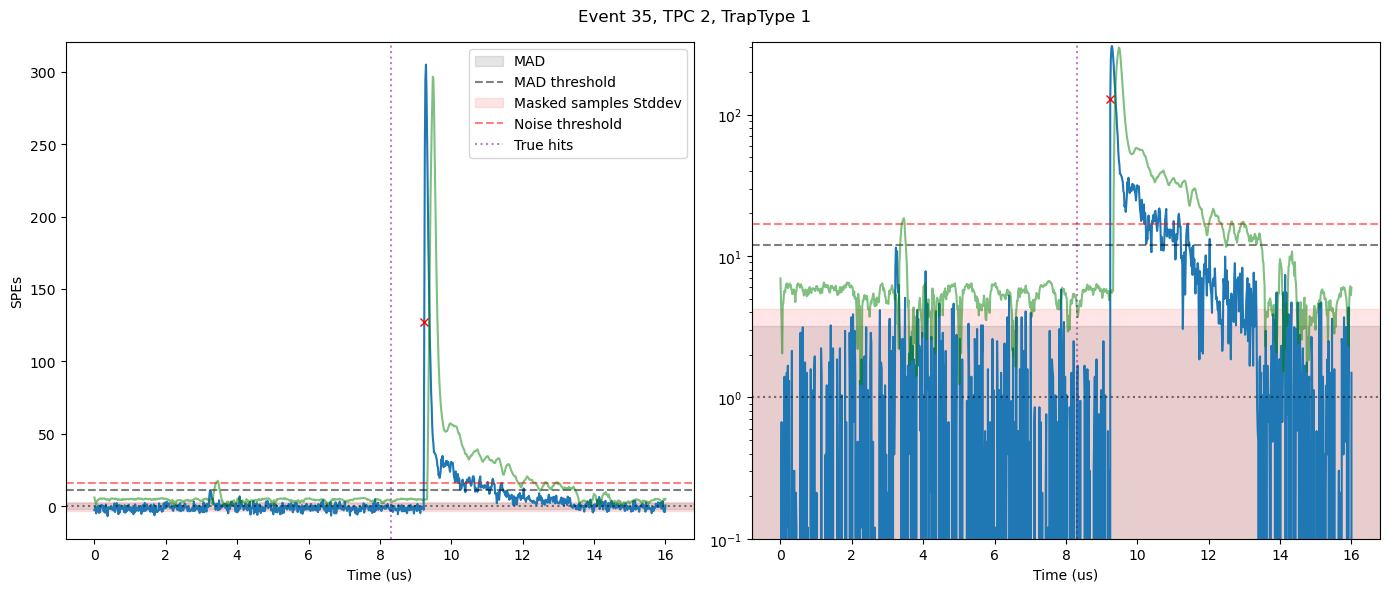

Event 74, TPC 3, TrapType 1 [81.] [428]


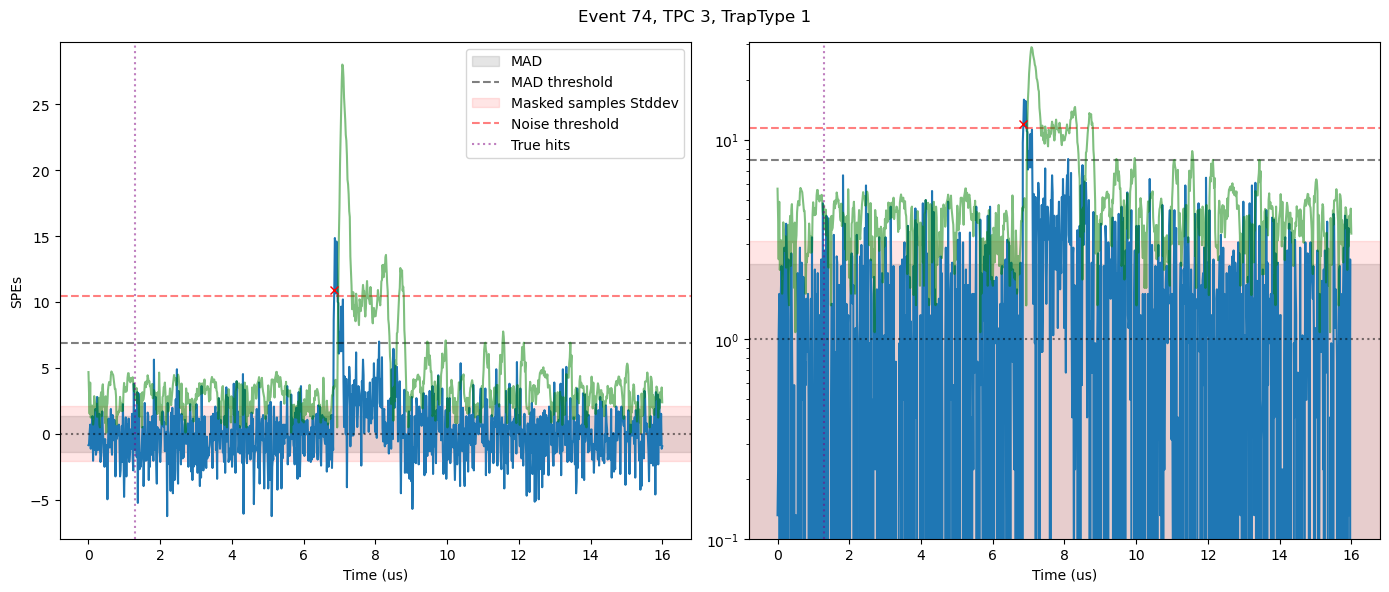

Event 83, TPC 0, TrapType 1 [552.] [361 364]


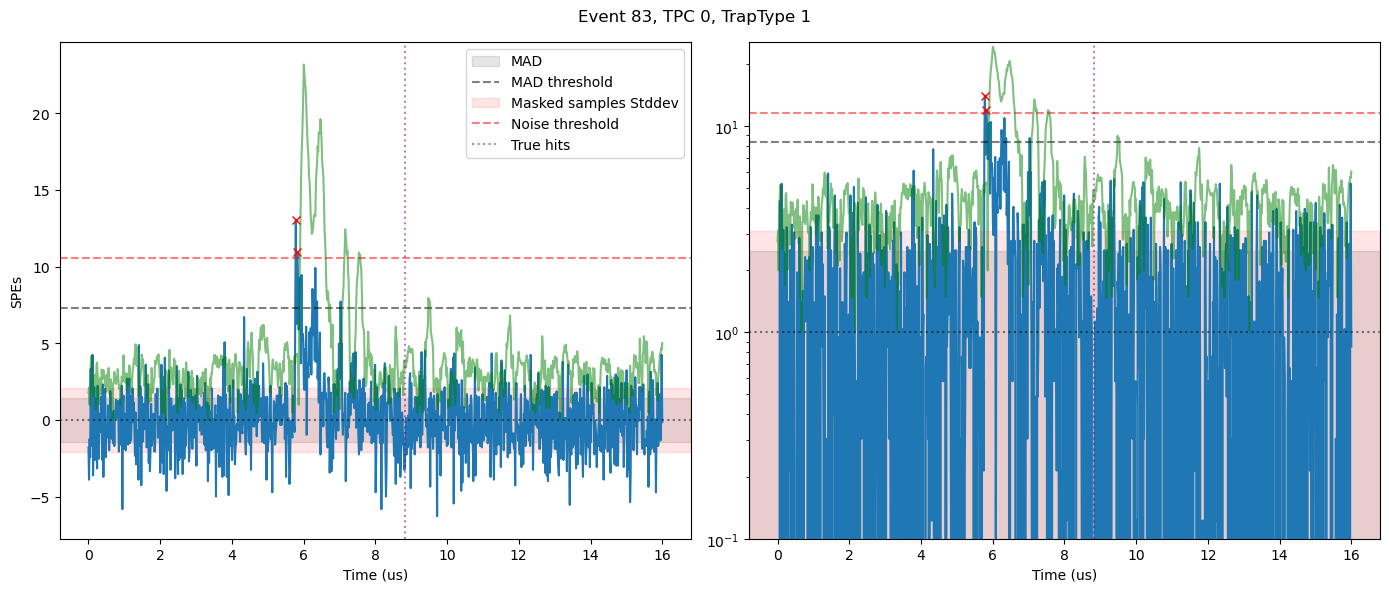

Event 109, TPC 3, TrapType 1 [14.] []


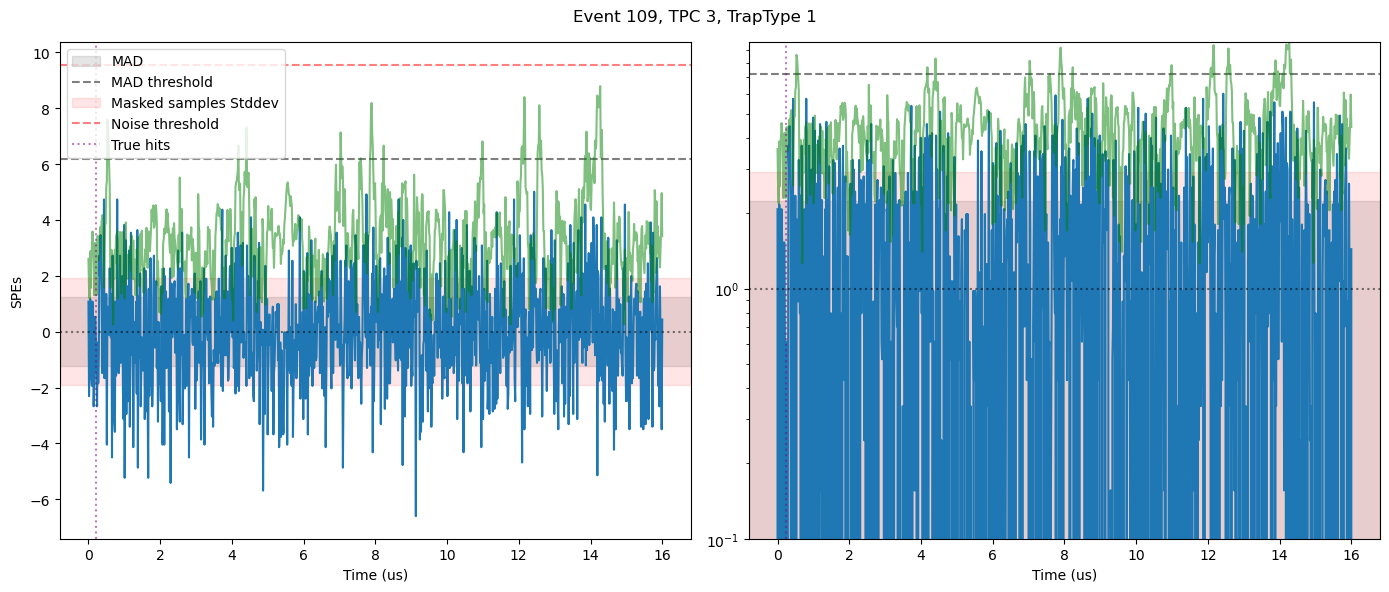

Event 117, TPC 3, TrapType 1 [56.] [556 723]


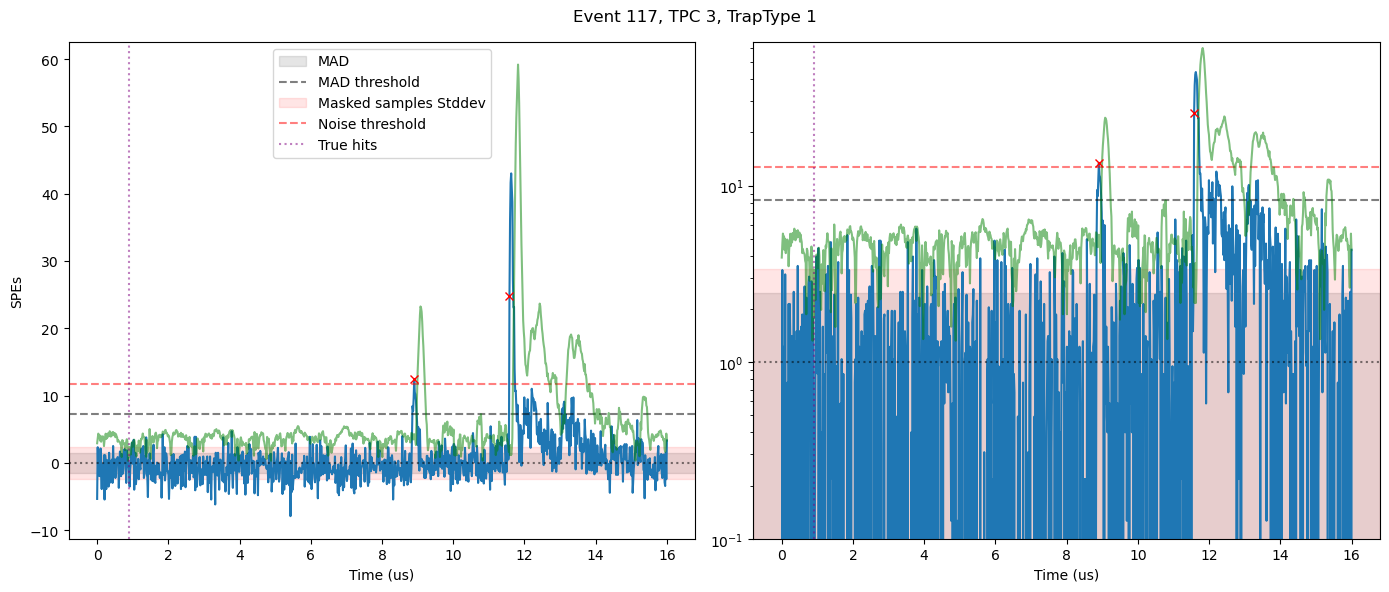

Event 138, TPC 0, TrapType 1 [252. 258.] [367]


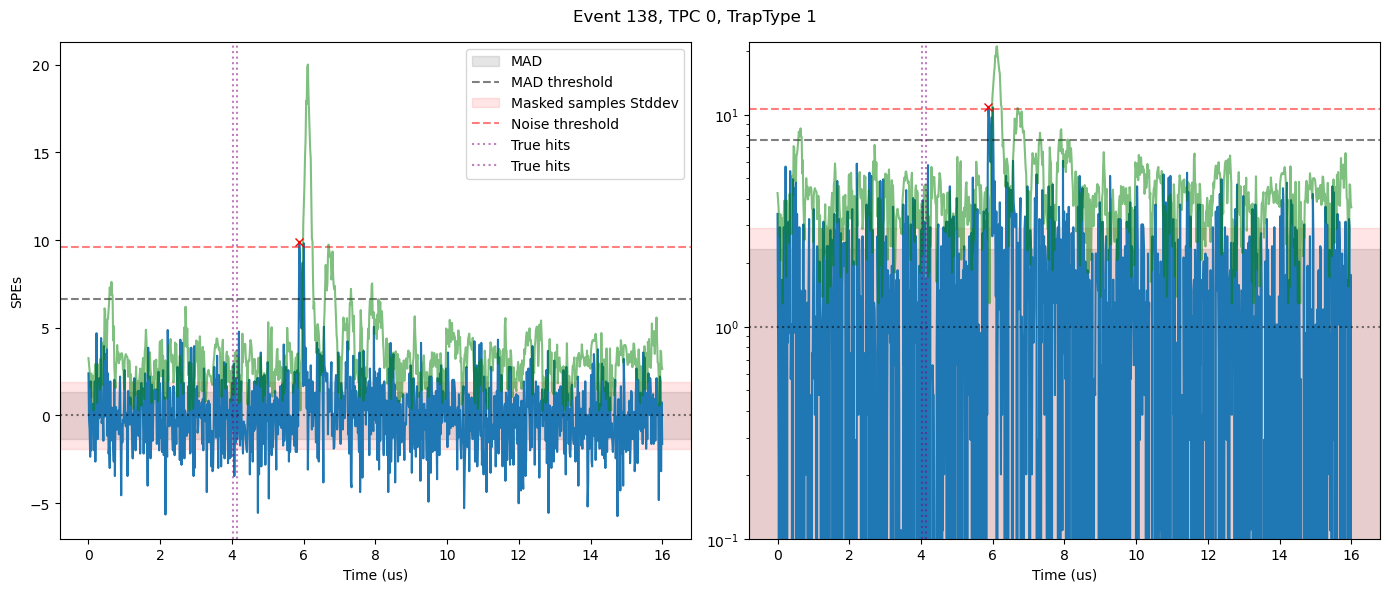

Event 160, TPC 0, TrapType 1 [319.] [171 428 430]


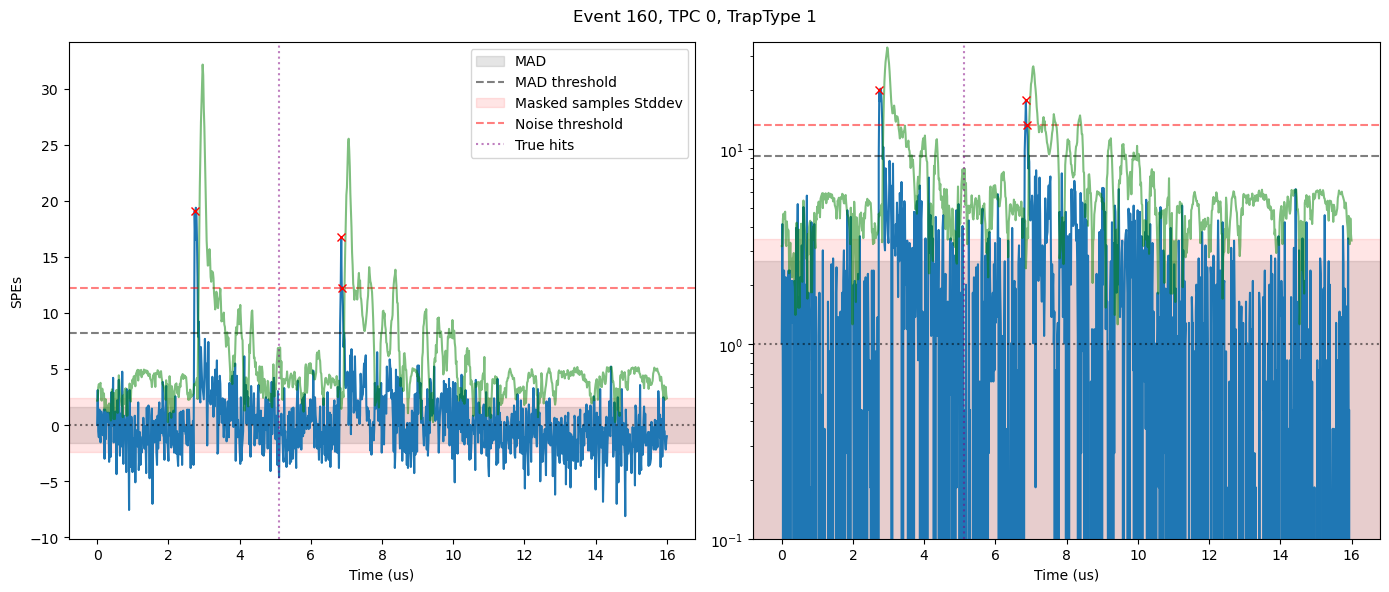

Event 186, TPC 0, TrapType 1 [76.] [271]


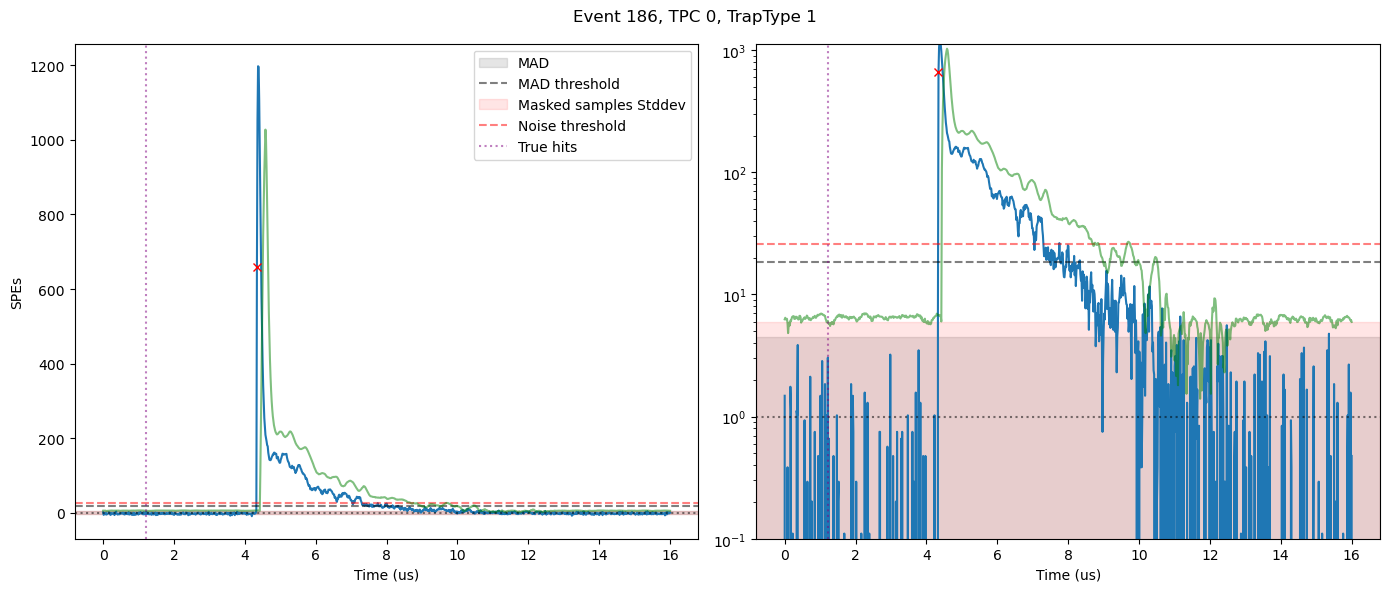

Event 188, TPC 3, TrapType 1 [340.] [377]


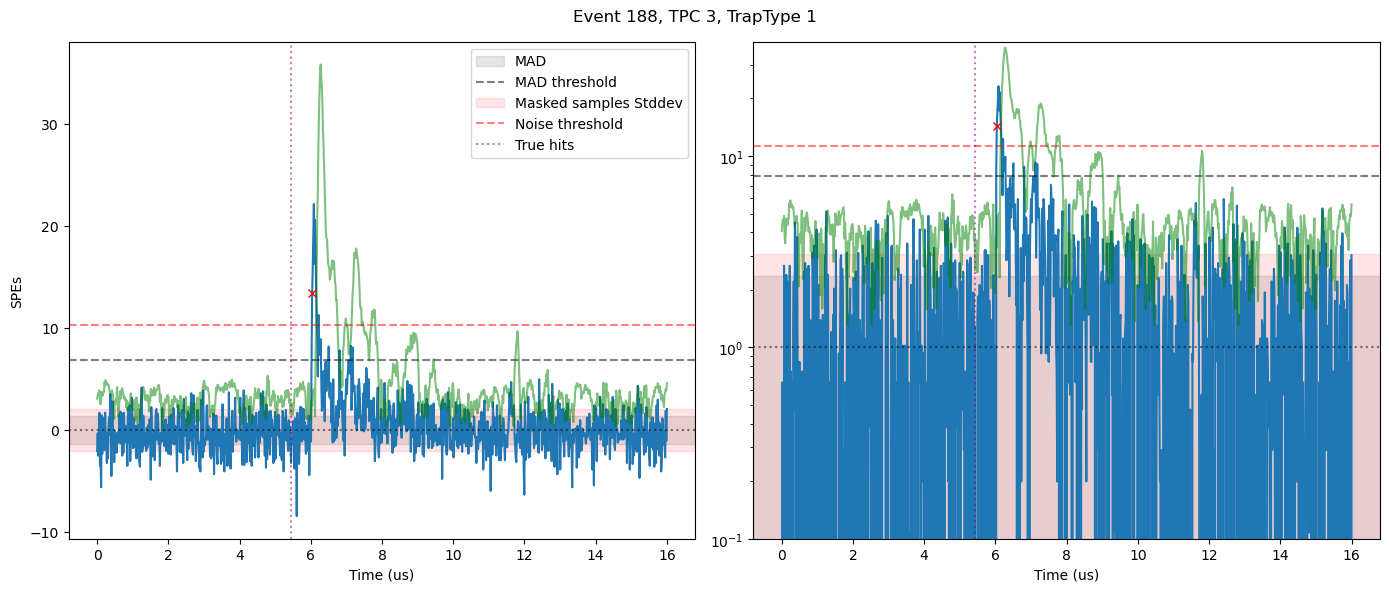

IndexError: index 192 is out of bounds for axis 0 with size 191

In [42]:
# loop over true_hits_tpc, grouped per event and tpc and save the vertices

# max event_id
max_event_id = int(true_hits['event_id'].max())

for i_evt_lrs in range(0, max_event_id):
    for i_tpc in range(0, 4):
        true_hits_evt = true_hits[(true_hits['tpc_num'] == i_tpc) & (true_hits['event_id'] == i_evt_lrs)]
        true_hits_idx = true_hits_evt['start_time_idx'].values
        if len(true_hits_idx) == 0:
            continue

        i_mask = 2*i_tpc + 1 # 2 * TPC + TrapType
        wvfm = summed_wvfms[i_evt_lrs,i_mask]
        median = np.median(wvfm)
        mad = np.median(np.abs(wvfm - median))
        mad_threshold = 5*mad
        wvfm_rolled = np.roll(wvfm, n_bins_rolled)
        rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
        sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
        dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
        height = heights[i_evt_lrs,i_mask]

        hit = hits[i_evt_lrs,i_mask]
        hit_where = np.where(hit)[0]

        print(f'Event {i_evt_lrs}, TPC {i_tpc}, TrapType {i_mask % 2}', true_hits_idx, hit_where)

        plot_waveform(wvfm, time_bins, height, mad, 5.0, dynamic_threshold, hit_where, n_noise_factor, i_evt_lrs, i_mask, true_hits_idx)

In [43]:
# plot the waveform of the trap with the highest wvfm in the event
for i_evt in range(0, summed_wvfms.shape[0]):

  # skip events with no hits
  all_traps = summed_wvfms[i_evt_lrs]
  all_heights = heights[i_evt_lrs]
  all_hits = hits[i_evt_lrs]

  # mask with the most hits
  i_mask = np.argmax(all_hits.sum(axis=1))
  i_evt_lrs = i_evt

  # get wvfm, threshold, and hits for the event
  wvfm = summed_wvfms[i_evt_lrs,i_mask]
  median = np.median(wvfm)
  mad = np.median(np.abs(wvfm - median))
  mad_threshold = 5*mad
  wvfm_rolled = np.roll(wvfm, n_bins_rolled)
  rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
  sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
  dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
  height = heights[i_evt_lrs,i_mask]

  hit = hits[i_evt_lrs,i_mask]
  hit_where = np.where(hit)[0]
  if len(hit_where) < 2:
    continue

  plot_waveform(wvfm, time_bins, height, mad, 5.0, dynamic_threshold, hit_where, n_noise_factor, i_evt_lrs, i_mask)

IndexError: index 192 is out of bounds for axis 0 with size 191